## Configuration for Colab

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install pyvirtualdisplay
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(600, 400))
    dis.start()

# 04. TD3

[Fujimoto, Scott, Herke van Hoof, and David Meger. "Addressing function approximation error in actor-critic methods." arXiv preprint arXiv:1802.09477 2018.](https://arxiv.org/pdf/1802.09477.pdf)

In value-based reinforcement learning methods, function approximation errors are known to lead to overestimated value estimates and suboptimal policies. However, similar issues with actor-critic methods in continuous control domains have been largely left untouched (See paper for detailed description). To solve this problem, this paper proposes *a clipped Double Q-learning*. In addtion, this paper contains a number of components that address variance reduction.

The author's modifications are applied to actor-critic method for continuous control, Deep Deterministic Policy Gradient algorithm ([DDPG](https://arxiv.org/pdf/1509.02971.pdf)), to form the *Twin Delayed Deep Deterministic policy gradient algorithm (TD3)*.

### DDPG
For learning in high-dimentional and continous action spaces, the authors of DDPG combine the actor-critic approach with insights from the success of DQN. Deep DPG(DDPG) is based on the deterministic policy gradient(DPG) algorithm ([Silver et al., 2014](http://proceedings.mlr.press/v32/silver14.pdf)). Please see *03.DDPG.ipynb* for detailed description of DDPG.

### Double Q-learning
In Double DQN ([Van Hasselt et al., 2016](https://arxiv.org/pdf/1509.06461.pdf)), the authors propose using the target network as one of the value estimates, and obtain a policy by greedy maximization of the current value network rather than the target network. In an actor-critic setting, an analogous update uses the current policy rather than the target policy in the learning target. However, with the slow-changing policy in actor-critic, the current and target networks were too similar to make an independent estimation, and offered little improvement. Instead, the original Double Q-learning formulation can be used, with a pair of actors $(\pi_{\phi_1}, \pi_{\phi_2})$ and critics $(Q_{\theta_1}, Q_{\theta_2})$, where $\pi_{\phi_1}$ is optimized with respect to $Q_{\theta_1}$ and $\pi_{\phi_2}$ with respect to $Q_{\theta_2}$:

$$
y_1 = r + \gamma Q_{\theta'_2} (s' , \pi_{\phi_1}(s')) \\
y_2 = r + \gamma Q_{\theta'_1} (s' , \pi_{\phi_2}(s'))
$$

### A clipped Double Q-learning
The critics are not entirely independent, due to the use of the opposite critic in the learning targets, as well as the same replay buffer. As a result, for some states we will have $Q_{\theta'_2}(s, \pi_{\phi_1}) > Q_{\theta'_1}(s, \pi_{\phi_1})$. This is problematic because $Q_{\theta'_1}(s, \pi_{\phi_1})$ will generally overestimate the true value, and in certain areas of the state space the overestimation will be further exaggerated. To address this problem, the authors propose to take the minimum between the two estimates:

$$
y_1 = r + \gamma \underset{i=1,2}{\min} Q_{\theta'_i} (s' , \pi_{\phi_1}(s'))
$$

### Delayed Policy Updates
If policy updates on high-error states cause different behavior, then the policy network should be updated at a lower frequency than the value network, to first minimize error before introducing a policy update. The authors propose delaying policy updates until the value error is as small as possible.

### Target Policy Smoothing Regularization
When updating the critic, a learning target using a deterministic policy is highly susceptible to in accuracies induced by function approximation error, increasing the variance of the target. This induced variance can be reduced through regularization. The authors propose that fitting the value of a small area around the target action

$$
y = r + E_\epsilon [Q_{\theta'}(s', \pi_{\phi '}(s') + \epsilon],
$$

would have the benefit of smoothing the value estimate by bootstrapping off of similar state-action value estimates. In practice, this makes below:

$$
y = r + \gamma Q_{\theta '}(s', \pi_{\phi '}(s') + \epsilon), \\
\epsilon \sim \text{clip} (\mathcal(N)(0, \sigma), -c, c),
$$

where the added noise is clipped to keep the target close tothe original action.

## import module

In [2]:
import copy
import os
import random
from typing import Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

## Set random seed

In [3]:
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Replay buffer
Typically, people implement replay buffers with one of the following three data structures:

- collections.deque
- list
- numpy.ndarray

**deque** is very easy to handle once you initialize its maximum length (e.g. deque(maxlen=buffer_size)). However, the indexing operation of deque gets terribly slow as it grows up because it is [internally doubly linked list](https://wiki.python.org/moin/TimeComplexity#collections.deque). On the other hands, **list** is an array, so it is relatively faster than deque when you sample batches at every step. Its amortized cost of Get item is [O(1)](https://wiki.python.org/moin/TimeComplexity#list).

Last but not least, let's see **numpy.ndarray**. numpy.ndarray is even faster than list due to the fact that it is [a homogeneous array of fixed-size items](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html#numpy.ndarray), so you can get the benefits of [locality of reference](https://en.wikipedia.org/wiki/Locality_of_reference), . Whereas list is an array of pointers to objects, even when all of them are of the same type.

Here, we are going to implement a replay buffer using numpy.ndarray.

Reference: 
- [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)
- [rainbow-is-all-you-need](https://render.githubusercontent.com/view/ipynb?commit=032d11277cf2436853478a69ca5a4aba03202598&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f437572742d5061726b2f7261696e626f772d69732d616c6c2d796f752d6e6565642f303332643131323737636632343336383533343738613639636135613461626130333230323539382f30312e64716e2e6970796e62&nwo=Curt-Park%2Frainbow-is-all-you-need&path=01.dqn.ipynb&repository_id=191133946&repository_type=Repository#Replay-buffer)

In [4]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )

    def __len__(self) -> int:
        return self.size

## Gaussian Noise
Because the DDPG and the TD3 policy is deterministic, it's not enough to explore a wide variety of actions. In order to facilitate more exploration. TD3 adds Gaussian noise to each action, while DDPG uses Ornstein-Uhlenbeck noise. The TD3 paper states Ornstein-Uhlenbeck noise offered no performance benefits.

In [5]:
class GaussianNoise:
    """Gaussian Noise.
    Taken from https://github.com/vitchyr/rlkit
    """

    def __init__(
        self,
        action_dim: int,
        min_sigma: float = 1.0,
        max_sigma: float = 1.0,
        decay_period: int = 1000000,
    ):
        """Initialize."""
        self.action_dim = action_dim
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period

    def sample(self, t: int = 0) -> float:
        """Get an action with gaussian noise."""
        sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(
            1.0, t / self.decay_period
        )
        return np.random.normal(0, sigma, size=self.action_dim)

## Network
We are going to use two separated networks for actor and critic. The actor network has three fully connected layers and three non-linearity functions, *ReLU* for hidden layers and *tanh* for the output layer. On the other hand, the critic network has three fully connected layers, but it used two activation functions for hidden layers *ReLU*. Plus, its input sizes of critic network are sum of state sizes and action sizes. One thing to note is that we initialize the final layer's weights and biases so that they are *uniformly distributed.*

In [6]:
class Actor(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, init_w: float = 3e-3):
        """Initialize."""
        super(Actor, self).__init__()

        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, out_dim)

        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        action = self.out(x).tanh()

        return action


class Critic(nn.Module):
    def __init__(self, in_dim: int, init_w: float = 3e-3):
        """Initialize."""
        super(Critic, self).__init__()

        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)

        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)

        return value

## TD3Agent
Here is a summary of TD3Agent class.

| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|\_target_soft_update| soft update from the local model to the target model.|
|\_plot              | plot the training progresses.                        |

In [7]:
class TD3Agent:
    """TD3Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        actor1 (nn.Module): target actor model to select actions
        actor2 (nn.Module): target actor model to select actions
        actor_target1 (nn.Module): actor model to predict next actions
        actor_target2 (nn.Module): actor model to predict next actions
        actor_optimizer (Optimizer): optimizer for training actor
        critic1 (nn.Module): critic model to predict state values
        critic2 (nn.Module): critic model to predict state values
        critic_target1 (nn.Module): target critic model to predict state values
        critic_target2 (nn.Module): target critic model to predict state values        
        critic_optimizer (Optimizer): optimizer for training critic
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        exploration_noise (GaussianNoise): gaussian noise for policy
        target_policy_noise (GaussianNoise): gaussian noise for target policy
        target_policy_noise_clip (float): clip target gaussian noise
        device (torch.device): cpu / gpu
        transition (list): temporory storage for the recent transition
        policy_update_freq (int): update actor every time critic updates this times
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """

    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        gamma: float = 0.99,
        tau: float = 5e-3,
        exploration_noise: float = 0.1,
        target_policy_noise: float = 0.2,
        target_policy_noise_clip: float = 0.5,
        initial_random_steps: int = int(1e4),
        policy_update_freq: int = 2,
    ):
        """Initialize."""
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
        self.policy_update_freq = policy_update_freq

        # device: cpu / gpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)

        # noise
        self.exploration_noise = GaussianNoise(
            action_dim, exploration_noise, exploration_noise
        )
        self.target_policy_noise = GaussianNoise(
            action_dim, target_policy_noise, target_policy_noise
        )
        self.target_policy_noise_clip = target_policy_noise_clip

        # networks
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())

        self.critic1 = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target1 = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target1.load_state_dict(self.critic1.state_dict())

        self.critic2 = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target2 = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target2.load_state_dict(self.critic2.state_dict())

        # concat critic parameters to use one optim
        critic_parameters = list(self.critic1.parameters()) + list(
            self.critic2.parameters()
        )

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optimizer = optim.Adam(critic_parameters, lr=1e-3)

        # transition to store in memory
        self.transition = list()

        # total steps count
        self.total_step = 0

        # update step for actor
        self.update_step = 0

        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # if initial random action should be conducted
        if self.total_step < self.initial_random_steps and not self.is_test:
            selected_action = self.env.action_space.sample()
        else:
            selected_action = (
                self.actor(torch.FloatTensor(state).to(self.device))[0]
                .detach()
                .cpu()
                .numpy()
            )

        # add noise for exploration during training
        if not self.is_test:
            noise = self.exploration_noise.sample()
            selected_action = np.clip(
                selected_action + noise, -1.0, 1.0
            )

            self.transition = [state, selected_action]

        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)

        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines

        samples = self.memory.sample_batch()
        states = torch.FloatTensor(samples["obs"]).to(device)
        next_states = torch.FloatTensor(samples["next_obs"]).to(device)
        actions = torch.FloatTensor(samples["acts"].reshape(-1, 1)).to(device)
        rewards = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        dones = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        masks = 1 - dones

        # get actions with noise
        noise = torch.FloatTensor(self.target_policy_noise.sample()).to(device)
        clipped_noise = torch.clamp(
            noise, -self.target_policy_noise_clip, self.target_policy_noise_clip
        )

        next_actions = (self.actor_target(next_states) + clipped_noise).clamp(
            -1.0, 1.0
        )

        # min (Q_1', Q_2')
        next_values1 = self.critic_target1(next_states, next_actions)
        next_values2 = self.critic_target2(next_states, next_actions)
        next_values = torch.min(next_values1, next_values2)

        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        curr_returns = rewards + self.gamma * next_values * masks
        curr_returns = curr_returns.detach()

        # critic loss
        values1 = self.critic1(states, actions)
        values2 = self.critic2(states, actions)
        critic1_loss = F.mse_loss(values1, curr_returns)
        critic2_loss = F.mse_loss(values2, curr_returns)

        # train critic
        critic_loss = critic1_loss + critic2_loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        if self.total_step % self.policy_update_freq == 0:
            # train actor
            actor_loss = -self.critic1(states, self.actor(states)).mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # target update
            self._target_soft_update()
        else:
            actor_loss = torch.zeros(1)

        return actor_loss.data, critic_loss.data

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False

        state = self.env.reset()
        actor_losses = []
        critic_losses = []
        scores = []
        score = 0

        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state = env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if (
                len(self.memory) >= self.batch_size
                and self.total_step > self.initial_random_steps
            ):
                actor_loss, critic_loss = self.update_model()
                actor_loss = actor_loss.to("cpu")
                critic_loss = critic_loss.to("cpu")
                actor_losses.append(actor_loss)
                critic_losses.append(critic_loss)

            # plotting
            if self.total_step % plotting_interval == 0:
                self._plot(self.total_step, scores, actor_losses, critic_losses)

        self.env.close()

    def test(self):
        """Test the agent."""
        self.is_test = True

        state = self.env.reset()
        done = False
        score = 0

        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        return frames

    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau
        for t_param, l_param in zip(
            self.actor_target.parameters(), self.actor.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

        for t_param, l_param in zip(
            self.critic_target1.parameters(), self.critic1.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

        for t_param, l_param in zip(
            self.critic_target2.parameters(), self.critic2.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        actor_losses: List[float],
        critic_losses: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(30, 5))
        plt.subplot(131)
        plt.title("frame %s. score: %s" % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title("actor_loss")
        plt.plot(actor_losses)
        plt.subplot(133)
        plt.title("critic_loss")
        plt.plot(critic_losses)
        plt.show()

## Environment
*ActionNormalizer* is an action wrapper class to normalize the action values ranged in (-1. 1). Thanks to this class, we can make the agent simply select action values within the zero centered range (-1, 1).

In [8]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

You can see [the code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py) and [configurations](https://github.com/openai/gym/blob/cedecb35e3428985fd4efad738befeb75b9077f1/gym/envs/__init__.py#L81) of Pendulum-v0 from OpenAI's repository.

In [9]:
# environment
env_id = "Pendulum-v1"
env = gym.make(env_id)
env = ActionNormalizer(env)
env.seed(seed)

[777]

## Initialize

In [10]:
# parameters
num_frames = 50000
memory_size = 100000
batch_size = 128
initial_random_steps = 10000

agent = TD3Agent(
    env, memory_size, batch_size, initial_random_steps=initial_random_steps
)

cuda


## Train

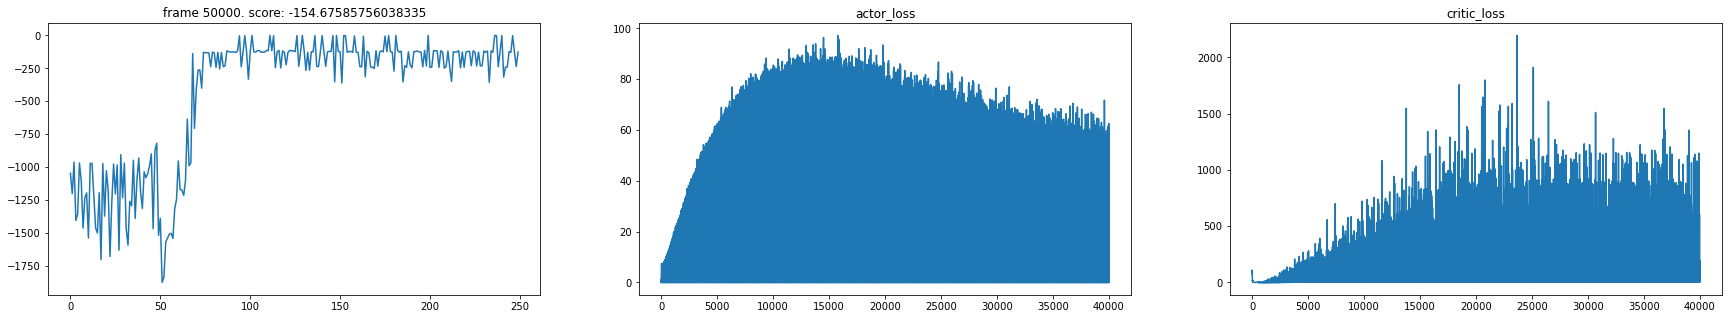

In [11]:
agent.train(num_frames)

## Test
Run the trained agent (1 episode).

In [14]:
for i in range(10):
    res = agent.test()

score:  -326.07504294519345
score:  -226.7035655230842
score:  -117.40473546266942
score:  -127.63392098478963
score:  -0.7483472888700275
score:  -122.14087887578205
score:  -115.35201165763743
score:  -357.4465819617195
score:  -131.15763530633043
score:  -128.84018509991733
